Chapter 5 presented basic DataFrame concepts and abstractions. This chapter covers building
expressions, which are the bread and butter of Spark’s structured operations. We also review
working with a variety of different kinds of data, including the following:
1. Booleans
2. Numbers
3. Strings
4. Dates and timestamps
5. Handling null
6. Complex types
7. User-defined functions

To begin, let’s read in the DataFrame that we’ll be using
for this analysis:

In [1]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext('local')
spark = SparkSession(sc)

In [2]:
df = spark.read.format("csv")\
.option("header", "true")\
.option("inferSchema", "true")\
.load("../data/retail-data/by-day/2010-12-01.csv")
df.printSchema()
df.createOrReplaceTempView("dfTable")

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: double (nullable = true)
 |-- Country: string (nullable = true)



In [3]:
df.show(2)

+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|2010-12-01 08:26:00|     2.55|   17850.0|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
only showing top 2 rows



# Converting to Spark Types
One thing you’ll see us do throughout this chapter is convert native types to Spark types. We do
this by using the first function that we introduce here, the lit function. This function converts a
type in another language to its correspnding Spark representation. Here’s how we can convert a
couple of different kinds of Scala and Python values to their respective Spark types:

In [4]:
from pyspark.sql.functions import lit
df.select(lit(5), lit("five"), lit(5.0))

DataFrame[5: int, five: string, 5.0: double]

In [6]:
#There’s no equivalent function necessary in SQL, so we can use the values directly:
#-- in SQL
#SELECT 5, "five", 5.0

# Working with Booleans
Booleans are essential when it comes to data analysis because they are the foundation for all
filtering. Boolean statements consist of four elements: and, or, true, and false. We use these
simple structures to build logical statements that evaluate to either true or false. These statements
are often used as conditional requirements for when a row of data must either pass the test
(evaluate to true) or else it will be filtered out.

Let’s use our retail dataset to explore working with Booleans. We can specify equality as well as
less-than or greater-than:

In [5]:
from pyspark.sql.functions import col
df.where(col("InvoiceNo") != 536365)\
.select("InvoiceNo", "Description")\
.show(5, False)

+---------+-----------------------------+
|InvoiceNo|Description                  |
+---------+-----------------------------+
|536366   |HAND WARMER UNION JACK       |
|536366   |HAND WARMER RED POLKA DOT    |
|536367   |ASSORTED COLOUR BIRD ORNAMENT|
|536367   |POPPY'S PLAYHOUSE BEDROOM    |
|536367   |POPPY'S PLAYHOUSE KITCHEN    |
+---------+-----------------------------+
only showing top 5 rows



In [6]:
from pyspark.sql.functions import col
df.where(col("InvoiceNo") != 536365)\
.select("InvoiceNo", "Description")\
.show(5, True)

+---------+--------------------+
|InvoiceNo|         Description|
+---------+--------------------+
|   536366|HAND WARMER UNION...|
|   536366|HAND WARMER RED P...|
|   536367|ASSORTED COLOUR B...|
|   536367|POPPY'S PLAYHOUSE...|
|   536367|POPPY'S PLAYHOUSE...|
+---------+--------------------+
only showing top 5 rows



Another option—and probably the cleanest—is to specify the predicate as an expression in a
string. This is valid for Python or Scala. Note that this also gives you access to another way of
expressing “does not equal”:

In [7]:
df.where("InvoiceNo = 536365").show(5, False)
df.where("InvoiceNo <> 536365").show(5, False)

+---------+---------+-----------------------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate        |UnitPrice|CustomerID|Country       |
+---------+---------+-----------------------------------+--------+-------------------+---------+----------+--------------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER |6       |2010-12-01 08:26:00|2.55     |17850.0   |United Kingdom|
|536365   |71053    |WHITE METAL LANTERN                |6       |2010-12-01 08:26:00|3.39     |17850.0   |United Kingdom|
|536365   |84406B   |CREAM CUPID HEARTS COAT HANGER     |8       |2010-12-01 08:26:00|2.75     |17850.0   |United Kingdom|
|536365   |84029G   |KNITTED UNION FLAG HOT WATER BOTTLE|6       |2010-12-01 08:26:00|3.39     |17850.0   |United Kingdom|
|536365   |84029E   |RED WOOLLY HOTTIE WHITE HEART.     |6       |2010-12-01 08:26:00|3.39     |17850.0   |United Kingdom|
+---------+-----

In [9]:
df.where("Description like 'HAND WARMER%'").show(5, False)

+---------+---------+-------------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|Description              |Quantity|InvoiceDate        |UnitPrice|CustomerID|Country       |
+---------+---------+-------------------------+--------+-------------------+---------+----------+--------------+
|536366   |22633    |HAND WARMER UNION JACK   |6       |2010-12-01 08:28:00|1.85     |17850.0   |United Kingdom|
|536366   |22632    |HAND WARMER RED POLKA DOT|6       |2010-12-01 08:28:00|1.85     |17850.0   |United Kingdom|
|536372   |22632    |HAND WARMER RED POLKA DOT|6       |2010-12-01 09:01:00|1.85     |17850.0   |United Kingdom|
|536372   |22633    |HAND WARMER UNION JACK   |6       |2010-12-01 09:01:00|1.85     |17850.0   |United Kingdom|
|536377   |22632    |HAND WARMER RED POLKA DOT|6       |2010-12-01 09:34:00|1.85     |17850.0   |United Kingdom|
+---------+---------+-------------------------+--------+-------------------+---------+----------

We mentioned that you can specify Boolean expressions with multiple parts when you use and
or or. In Spark, you should always chain together and filters as a sequential filter.

The reason for this is that even if Boolean statements are expressed serially (one after the other),
Spark will flatten all of these filters into one statement and perform the filter at the same time,
creating the and statement for us. Although you can specify your statements explicitly by using
and if you like, they’re often easier to understand and to read if you specify them serially. or
statements need to be specified in the same statement:

In [10]:
# in Python
from pyspark.sql.functions import instr
priceFilter = col("UnitPrice") > 600
descripFilter = instr(df.Description, "POSTAGE") >= 1
df.where(df.StockCode.isin("DOT")).where(priceFilter | descripFilter).show()
#-- in SQL
#SELECT * FROM dfTable WHERE StockCode in ("DOT") AND(UnitPrice > 600 OR
#instr(Description, "POSTAGE") >= 1)

+---------+---------+--------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|   Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------+--------+-------------------+---------+----------+--------------+
|   536544|      DOT|DOTCOM POSTAGE|       1|2010-12-01 14:32:00|   569.77|      null|United Kingdom|
|   536592|      DOT|DOTCOM POSTAGE|       1|2010-12-01 17:06:00|   607.49|      null|United Kingdom|
+---------+---------+--------------+--------+-------------------+---------+----------+--------------+



In [14]:
spark.sql('SELECT * FROM dfTable WHERE StockCode in ("DOT") \
          AND(UnitPrice > 600 OR instr(Description, "POSTAGE") >= 1)').show(2)

+---------+---------+--------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|   Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------+--------+-------------------+---------+----------+--------------+
|   536544|      DOT|DOTCOM POSTAGE|       1|2010-12-01 14:32:00|   569.77|      null|United Kingdom|
|   536592|      DOT|DOTCOM POSTAGE|       1|2010-12-01 17:06:00|   607.49|      null|United Kingdom|
+---------+---------+--------------+--------+-------------------+---------+----------+--------------+



Boolean expressions are not just reserved to filters. To filter a DataFrame, you can also just
specify a Boolean column:

In [15]:
from pyspark.sql.functions import instr
DOTCodeFilter = col("StockCode") == "DOT"
priceFilter = col("UnitPrice") > 600
descripFilter = instr(col("Description"), "POSTAGE") >= 1
df.withColumn("isExpensive", DOTCodeFilter & (priceFilter | descripFilter))\
.where("isExpensive")\
.select("unitPrice", "isExpensive").show(5)
#-- in SQL
#SELECT UnitPrice, (StockCode = 'DOT' AND
#(UnitPrice > 600 OR instr(Description, "POSTAGE") >= 1)) as isExpensive
#FROM dfTable
#WHERE (StockCode = 'DOT' AND
#(UnitPrice > 600 OR instr(Description, "POSTAGE") >= 1))

+---------+-----------+
|unitPrice|isExpensive|
+---------+-----------+
|   569.77|       true|
|   607.49|       true|
+---------+-----------+



Notice how we did not need to specify our filter as an expression and how we could use a
column name without any extra work.

If you’re coming from a SQL background, all of these statements should seem quite familiar.
Indeed, all of them can be expressed as a where clause. In fact, it’s often easier to just express
filters as SQL statements than using the programmatic DataFrame interface and Spark SQL
allows us to do this without paying any performance penalty. For example, the following two
statements are equivalent:

In [16]:
from pyspark.sql.functions import expr
df.withColumn("isExpensive", expr("NOT UnitPrice <= 250"))\
.where("isExpensive")\
.select("Description", "UnitPrice").show(5)

+--------------+---------+
|   Description|UnitPrice|
+--------------+---------+
|DOTCOM POSTAGE|   569.77|
|DOTCOM POSTAGE|   607.49|
+--------------+---------+



## WARNING
One “gotcha” that can come up is if you’re working with null data when creating Boolean expressions.
If there is a null in your data, you’ll need to treat things a bit differently. Here’s how you can ensure
that you perform a null-safe equivalence test:

In [17]:
df.where(col("Description").eqNullSafe("hello")).show()

+---------+---------+-----------+--------+-----------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|InvoiceDate|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+-----------+---------+----------+-------+
+---------+---------+-----------+--------+-----------+---------+----------+-------+



In [21]:
df.where(col("Description") == "hello").show()

+---------+---------+-----------+--------+-----------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|InvoiceDate|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+-----------+---------+----------+-------+
+---------+---------+-----------+--------+-----------+---------+----------+-------+



In [18]:

df.where(col("Description").eqNullSafe("DOTCOM POSTAGE")).show()

+---------+---------+--------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|   Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------+--------+-------------------+---------+----------+--------------+
|   536544|      DOT|DOTCOM POSTAGE|       1|2010-12-01 14:32:00|   569.77|      null|United Kingdom|
|   536592|      DOT|DOTCOM POSTAGE|       1|2010-12-01 17:06:00|   607.49|      null|United Kingdom|
+---------+---------+--------------+--------+-------------------+---------+----------+--------------+



# Working with Numbers
When working with big data, the second most common task you will do after filtering things is
counting things. For the most part, we simply need to express our computation, and that should
be valid assuming that we’re working with numerical data types.

To fabricate a contrived example, let’s imagine that we found out that we mis-recorded the
quantity in our retail dataset and the true quantity is equal to (the current quantity * the unit
price) + 5. This will introduce our first numerical function as well as the pow function that raises
a column to the expressed power:

In [22]:
from pyspark.sql.functions import expr, pow
fabricatedQuantity = pow(col("Quantity") * col("UnitPrice"), 2) + 5
df.select(expr("CustomerId"), fabricatedQuantity.alias("realQuantity")).show(2)

+----------+------------------+
|CustomerId|      realQuantity|
+----------+------------------+
|   17850.0|239.08999999999997|
|   17850.0|          418.7156|
+----------+------------------+
only showing top 2 rows



Notice that we were able to multiply our columns together because they were both numerical.
Naturally we can add and subtract as necessary, as well. In fact, we can do all of this as a SQL
expression, as well:

In [23]:
# in Python
df.selectExpr(
"CustomerId",
"(POWER((Quantity * UnitPrice), 2.0) + 5) as realQuantity").show(2)
#-- in SQL
#SELECT customerId, (POWER((Quantity * UnitPrice), 2.0) + 5) as realQuantity
#FROM dfTable

+----------+------------------+
|CustomerId|      realQuantity|
+----------+------------------+
|   17850.0|239.08999999999997|
|   17850.0|          418.7156|
+----------+------------------+
only showing top 2 rows



Another common numerical task is rounding. If you’d like to just round to a whole number,
oftentimes you can cast the value to an integer and that will work just fine. However, Spark also
has more detailed functions for performing this explicitly and to a certain level of precision. In
the following example, we round to one decimal place:

By default, the round function rounds up if you’re exactly in between two numbers. You can
round down by using the bround:

In [24]:
from pyspark.sql.functions import lit, round, bround
df.select(round(lit("2.5")), bround(lit("2.5"))).show(2)
#-- in SQL
#SELECT round(2.5), bround(2.5)

+-------------+--------------+
|round(2.5, 0)|bround(2.5, 0)|
+-------------+--------------+
|          3.0|           2.0|
|          3.0|           2.0|
+-------------+--------------+
only showing top 2 rows



Another numerical task is to compute the correlation of two columns. For example, we can see
the Pearson correlation coefficient for two columns to see if cheaper things are typically bought
in greater quantities. We can do this through a function as well as through the DataFrame
statistic methods:

In [25]:
# in Python
from pyspark.sql.functions import corr
df.stat.corr("Quantity", "UnitPrice")
df.select(corr("Quantity", "UnitPrice")).show()
#-- in SQL
#SELECT corr(Quantity, UnitPrice) FROM dfTable

+-------------------------+
|corr(Quantity, UnitPrice)|
+-------------------------+
|     -0.04112314436835551|
+-------------------------+



Another common task is to compute summary statistics for a column or set of columns. We can
use the describe method to achieve exactly this. This will take all numeric columns and
calculate the count, mean, standard deviation, min, and max. You should use this primarily for
viewing in the console because the schema might change in the future:

In [20]:
df.describe().show()

+-------+-----------------+------------------+--------------------+------------------+-------------------+------------------+------------------+--------------+
|summary|        InvoiceNo|         StockCode|         Description|          Quantity|        InvoiceDate|         UnitPrice|        CustomerID|       Country|
+-------+-----------------+------------------+--------------------+------------------+-------------------+------------------+------------------+--------------+
|  count|             3108|              3108|                3098|              3108|               3108|              3108|              1968|          3108|
|   mean| 536516.684944841|27834.304044117645|                null| 8.627413127413128|               null| 4.151946589446603|15661.388719512195|          null|
| stddev|72.89447869788873|17407.897548583845|                null|26.371821677029203|               null|15.638659854603892|1854.4496996893627|          null|
|    min|           536365|             

If you need these exact numbers, you can also perform this as an aggregation yourself by
importing the functions and applying them to the columns that you need:

In [21]:
from pyspark.sql.functions import count, mean, stddev_pop, min, max

There are a number of statistical functions available in the StatFunctions Package (accessible
using stat as we see in the code block below). These are DataFrame methods that you can use
to calculate a variety of different things. For instance, you can calculate either exact or
approximate quantiles of your data using the approxQuantile method:

In [26]:
colName = "UnitPrice"
quantileProbs = [0.5]
relError = 0.05
df.stat.approxQuantile("UnitPrice", quantileProbs, relError) # 2.51

[2.51]

You also can use this to see a cross-tabulation or frequent item pairs (be careful, this output will
be large and is omitted for this reason):

In [27]:
df.stat.crosstab("StockCode", "Quantity").show()

+------------------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
|StockCode_Quantity| -1|-10|-12| -2|-24| -3| -4| -5| -6| -7|  1| 10|100| 11| 12|120|128| 13| 14|144| 15| 16| 17| 18| 19|192|  2| 20|200| 21|216| 22| 23| 24| 25|252| 27| 28|288|  3| 30| 32| 33| 34| 36|384|  4| 40|432| 47| 48|480|  5| 50| 56|  6| 60|600| 64|  7| 70| 72|  8| 80|  9| 96|
+------------------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
|             22578|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0| 

In [28]:
df.stat.freqItems(["StockCode", "Quantity"]).show()

+--------------------+--------------------+
| StockCode_freqItems|  Quantity_freqItems|
+--------------------+--------------------+
|[90214E, 20728, 2...|[200, 128, 23, 32...|
+--------------------+--------------------+



As a last note, we can also add a unique ID to each row by using the function
monotonically_increasing_id. This function generates a unique value for each row, starting
with 0:

In [30]:
# in Python
from pyspark.sql.functions import monotonically_increasing_id
df.select(monotonically_increasing_id().alias('ID')).show(2)

+---+
| ID|
+---+
|  0|
|  1|
+---+
only showing top 2 rows



There are functions added with every release, so check the documentation for more methods. For
instance, there are some random data generation tools (e.g., rand(), randn()) with which you
can randomly generate data; however, there are potential determinism issues when doing so.
(You can find discussions about these challenges on the Spark mailing list.) There are also a
number of more advanced tasks like bloom filtering and sketching algorithms available in the
stat package that we mentioned (and linked to) at the beginning of this chapter. Be sure to search
the API documentation for more information and functions.

# Working with Strings
String manipulation shows up in nearly every data flow, and it’s worth explaining what you can
do with strings. You might be manipulating log files performing regular expression extraction or
substitution, or checking for simple string existence, or making all strings uppercase or
lowercase.

Let’s begin with the last task because it’s the most straightforward. The initcap function will
capitalize every word in a given string when that word is separated from another by a space.

In [31]:
# in Python
from pyspark.sql.functions import initcap
df.select(initcap(col("Description"))).show()
#-- in SQL
#SELECT initcap(Description) FROM dfTable

+--------------------+
|initcap(Description)|
+--------------------+
|White Hanging Hea...|
| White Metal Lantern|
|Cream Cupid Heart...|
|Knitted Union Fla...|
|Red Woolly Hottie...|
|Set 7 Babushka Ne...|
|Glass Star Froste...|
|Hand Warmer Union...|
|Hand Warmer Red P...|
|Assorted Colour B...|
|Poppy's Playhouse...|
|Poppy's Playhouse...|
|Feltcraft Princes...|
|Ivory Knitted Mug...|
|Box Of 6 Assorted...|
|Box Of Vintage Ji...|
|Box Of Vintage Al...|
|Home Building Blo...|
|Love Building Blo...|
|Recipe Box With M...|
+--------------------+
only showing top 20 rows



As just mentioned, you can cast strings in uppercase and lowercase, as well:

In [32]:
from pyspark.sql.functions import lower, upper
df.select(col("Description"),
lower(col("Description")),
upper(lower(col("Description")))).show(2)
#-- in SQL
#SELECT Description, lower(Description), Upper(lower(Description)) FROM dfTable

+--------------------+--------------------+-------------------------+
|         Description|  lower(Description)|upper(lower(Description))|
+--------------------+--------------------+-------------------------+
|WHITE HANGING HEA...|white hanging hea...|     WHITE HANGING HEA...|
| WHITE METAL LANTERN| white metal lantern|      WHITE METAL LANTERN|
+--------------------+--------------------+-------------------------+
only showing top 2 rows



Another trivial task is adding or removing spaces around a string. You can do this by using lpad,
ltrim, rpad and rtrim, trim:

In [33]:
# in Python
from pyspark.sql.functions import lit, ltrim, rtrim, rpad, lpad, trim
df.select(
ltrim(lit(" HELLO ")).alias("ltrim"),
rtrim(lit(" HELLO ")).alias("rtrim"),
trim(lit(" HELLO ")).alias("trim"),
lpad(lit("HELLO"), 3, " ").alias("lp"),
rpad(lit("HELLO"), 10, " ").alias("rp")).show(2)
#-- in SQL
#SELECT
#ltrim(' HELLLOOOO '),
#rtrim(' HELLLOOOO '),
#trim(' HELLLOOOO '),
#lpad('HELLOOOO ', 3, ' '),
#rpad('HELLOOOO ', 10, ' ')
#FROM dfTable

+------+------+-----+---+----------+
| ltrim| rtrim| trim| lp|        rp|
+------+------+-----+---+----------+
|HELLO | HELLO|HELLO|HEL|HELLO     |
|HELLO | HELLO|HELLO|HEL|HELLO     |
+------+------+-----+---+----------+
only showing top 2 rows



In [35]:
df.select(
ltrim(lit(" HELLO ")).alias("ltrim")).show(2)

+------+
| ltrim|
+------+
|HELLO |
|HELLO |
+------+
only showing top 2 rows



Note that if lpad or rpad takes a number less than the length of the string, it will always remove
values from the right side of the string.
## Regular Expressions
Probably one of the most frequently performed tasks is searching for the existence of one string
in another or replacing all mentions of a string with another value. This is often done with a tool
called regular expressions that exists in many programming languages. Regular expressions give
the user an ability to specify a set of rules to use to either extract values from a string or replace
them with some other values.

Spark takes advantage of the complete power of Java regular expressions. The Java regular
expression syntax departs slightly from other programming languages, so it is worth reviewing
before putting anything into production. There are two key functions in Spark that you’ll need in
order to perform regular expression tasks: regexp_extract and regexp_replace. These
functions extract values and replace values, respectively.

Let’s explore how to use the regexp_replace function to replace substitute color names in our
description column:

In [36]:
# in Python
from pyspark.sql.functions import regexp_replace
regex_string = "BLACK|WHITE|RED|GREEN|BLUE"
df.select(
regexp_replace(col("Description"), regex_string, "COLOR").alias("color_clean"),
col("Description")).show(2)
#-- in SQL
#SELECT
#regexp_replace(Description, 'BLACK|WHITE|RED|GREEN|BLUE', 'COLOR') as
#color_clean, Description
#FROM dfTable

+--------------------+--------------------+
|         color_clean|         Description|
+--------------------+--------------------+
|COLOR HANGING HEA...|WHITE HANGING HEA...|
| COLOR METAL LANTERN| WHITE METAL LANTERN|
+--------------------+--------------------+
only showing top 2 rows



Another task might be to replace given characters with other characters. Building this as a
regular expression could be tedious, so Spark also provides the translate function to replace these
values. This is done at the character level and will replace all instances of a character with the
indexed character in the replacement string:

In [37]:
# in Python
from pyspark.sql.functions import translate
df.select(translate(col("Description"), "LEET", "1357"),col("Description"))\
.show(2)
#-- in SQL
#SELECT translate(Description, 'LEET', '1337'), Description FROM dfTable

+----------------------------------+--------------------+
|translate(Description, LEET, 1357)|         Description|
+----------------------------------+--------------------+
|              WHI73 HANGING H3A...|WHITE HANGING HEA...|
|               WHI73 M37A1 1AN73RN| WHITE METAL LANTERN|
+----------------------------------+--------------------+
only showing top 2 rows



We can also perform something similar, like pulling out the first mentioned color:

In [31]:
# in Python
from pyspark.sql.functions import regexp_extract
extract_str = "(BLACK|WHITE|RED|GREEN|BLUE)"
df.select(
regexp_extract(col("Description"), extract_str, 1).alias("color_clean"),
col("Description")).show(2)
#-- in SQL
#SELECT regexp_extract(Description, '(BLACK|WHITE|RED|GREEN|BLUE)', 1),
#Description
#FROM dfTable

+-----------+--------------------+
|color_clean|         Description|
+-----------+--------------------+
|      WHITE|WHITE HANGING HEA...|
|      WHITE| WHITE METAL LANTERN|
+-----------+--------------------+
only showing top 2 rows



Sometimes, rather than extracting values, we simply want to check for their existence. We can do
this with the contains method on each column. This will return a Boolean declaring whether the
value you specify is in the column’s string (In Python and SQL, we can use the instr function):

In [32]:
# in Python
from pyspark.sql.functions import instr
containsBlack = instr(col("Description"), "BLACK") >= 1
containsWhite = instr(col("Description"), "WHITE") >= 1
df.withColumn("hasSimpleColor", containsBlack | containsWhite)\
.where("hasSimpleColor")\
.select("Description").show(3, False)
#-- in SQL
#SELECT Description FROM dfTable
#WHERE instr(Description, 'BLACK') >= 1 OR instr(Description, 'WHITE') >= 1

+----------------------------------+
|Description                       |
+----------------------------------+
|WHITE HANGING HEART T-LIGHT HOLDER|
|WHITE METAL LANTERN               |
|RED WOOLLY HOTTIE WHITE HEART.    |
+----------------------------------+
only showing top 3 rows



This is trivial with just two values, but it becomes more complicated when there are values.

Let’s work through this in a more rigorous way and take advantage of Spark’s ability to accept a
dynamic number of arguments. When we convert a list of values into a set of arguments and pass
them into a function, we use a language feature called varargs. Using this feature, we can
effectively unravel an array of arbitrary length and pass it as arguments to a function. This,
coupled with select makes it possible for us to create arbitrary numbers of columns
dynamically:

In Python, we’re going to use a different function,
locate, that returns the integer location (1 based location). We then convert that to a Boolean
before using it as the same basic feature:

In [35]:
from pyspark.sql.functions import expr, locate
simpleColors = ["black", "white", "red", "green", "blue"]
def color_locator(column, color_string):
    return locate(color_string.upper(), column)\
    .cast("boolean")\
    .alias("is_" + color_string)
selectedColumns = [color_locator(df.Description, c) for c in simpleColors]
selectedColumns.append(expr("*")) # has to a be Column type
df.select(*selectedColumns).where(expr("is_white OR is_red"))\
.select("Description").show(3, False)

+----------------------------------+
|Description                       |
+----------------------------------+
|WHITE HANGING HEART T-LIGHT HOLDER|
|WHITE METAL LANTERN               |
|RED WOOLLY HOTTIE WHITE HEART.    |
+----------------------------------+
only showing top 3 rows



This simple feature can often help you programmatically generate columns or Boolean filters in a
way that is simple to understand and extend. We could extend this to calculating the smallest
common denominator for a given input value, or whether a number is a prime.
# Working with Dates and Timestamps
Spark, as we saw with our current dataset, will make a best effort to
correctly identify column types, including dates and timestamps when we enable inferSchema

As we hinted earlier, working with dates and timestamps closely relates to working with strings
because we often store our timestamps or dates as strings and convert them into date types at
runtime. This is less common when working with databases and structured data but much more
common when we are working with text and CSV files.

Although Spark will do read dates or times on a best-effort basis. However, sometimes there will
be no getting around working with strangely formatted dates and times. The key to
understanding the transformations that you are going to need to apply is to ensure that you know
exactly what type and format you have at each given step of the way. Another common “gotcha”
is that Spark’s TimestampType class supports only second-level precision, which means that if
you’re going to be working with milliseconds or microseconds, you’ll need to work around this
problem by potentially operating on them as longs. Any more precision when coercing to a
TimestampType will be removed.

Spark can be a bit particular about what format you have at any given point in time. It’s
important to be explicit when parsing or converting to ensure that there are no issues in doing so.
At the end of the day, Spark is working with Java dates and timestamps and therefore conforms
to those standards. Let’s begin with the basics and get the current date and the current
timestamps:

In [36]:
from pyspark.sql.functions import current_date, current_timestamp
dateDF = spark.range(10)\
.withColumn("today", current_date())\
.withColumn("now", current_timestamp())
dateDF.createOrReplaceTempView("dateTable")
dateDF.printSchema()

root
 |-- id: long (nullable = false)
 |-- today: date (nullable = false)
 |-- now: timestamp (nullable = false)



Now that we have a simple DataFrame to work with, let’s add and subtract five days from today.
These functions take a column and then the number of days to either add or subtract as the
arguments:

In [37]:
# in Python
from pyspark.sql.functions import date_add, date_sub
dateDF.select(date_sub(col("today"), 5), date_add(col("today"), 5)).show(1)
#-- in SQL
#SELECT date_sub(today, 5), date_add(today, 5) FROM dateTable

+------------------+------------------+
|date_sub(today, 5)|date_add(today, 5)|
+------------------+------------------+
|        2020-09-26|        2020-10-06|
+------------------+------------------+
only showing top 1 row



Another common task is to take a look at the difference between two dates. We can do this with
the datediff function that will return the number of days in between two dates. Most often we
just care about the days, and because the number of days varies from month to month, there also
exists a function, months_between, that gives you the number of months between two dates:

In [38]:
# in Python
from pyspark.sql.functions import datediff, months_between, to_date
dateDF.withColumn("week_ago", date_sub(col("today"), 7))\
.select(datediff(col("week_ago"), col("today"))).show(1)
dateDF.select(
to_date(lit("2016-01-01")).alias("start"),
to_date(lit("2017-05-22")).alias("end"))\
.select(months_between(col("start"), col("end"))).show(1)
#-- in SQL
#SELECT to_date('2016-01-01'), months_between('2016-01-01', '2017-01-01'),
#datediff('2016-01-01', '2017-01-01')
#FROM dateTable

+-------------------------+
|datediff(week_ago, today)|
+-------------------------+
|                       -7|
+-------------------------+
only showing top 1 row

+--------------------------------+
|months_between(start, end, true)|
+--------------------------------+
|                    -16.67741935|
+--------------------------------+
only showing top 1 row



Notice that we introduced a new function: the to_date function. The to_date function allows
you to convert a string to a date, optionally with a specified format. We specify our format in the
Java SimpleDateFormat which will be important to reference if you use this function:

In [39]:
# in Python
from pyspark.sql.functions import to_date, lit
spark.range(5).withColumn("date", lit("2017-01-01"))\
.select(to_date(col("date"))).show(1)

+---------------+
|to_date(`date`)|
+---------------+
|     2017-01-01|
+---------------+
only showing top 1 row



Spark will not throw an error if it cannot parse the date; rather, it will just return null. This can
be a bit tricky in larger pipelines because you might be expecting your data in one format and
getting it in another. To illustrate, let’s take a look at the date format that has switched from yearmonth-
day to year-day-month. Spark will fail to parse this date and silently return null instead:

In [40]:
dateDF.select(to_date(lit("2016-20-12")),to_date(lit("2017-12-11"))).show(1)

+---------------------+---------------------+
|to_date('2016-20-12')|to_date('2017-12-11')|
+---------------------+---------------------+
|                 null|           2017-12-11|
+---------------------+---------------------+
only showing top 1 row



We find this to be an especially tricky situation for bugs because some dates might match the
correct format, whereas others do not. In the previous example, notice how the second date
appears as Decembers 11th instead of the correct day, November 12th. Spark doesn’t throw an
error because it cannot know whether the days are mixed up or that specific row is incorrect.

Let’s fix this pipeline, step by step, and come up with a robust way to avoid these issues entirely.
The first step is to remember that we need to specify our date format according to the Java
SimpleDateFormat standard.

We will use two functions to fix this: to_date and to_timestamp. The former optionally
expects a format, whereas the latter requires one:

In [41]:
# in Python
from pyspark.sql.functions import to_date
dateFormat = "yyyy-dd-MM"
cleanDateDF = spark.range(1).select(
to_date(lit("2017-12-11"), dateFormat).alias("date"),
to_date(lit("2017-20-12"), dateFormat).alias("date2"))
cleanDateDF.createOrReplaceTempView("dateTable2")
#-- in SQL
#SELECT to_date(date, 'yyyy-dd-MM'), to_date(date2, 'yyyy-dd-MM'), to_date(date)
#FROM dateTable2

Now let’s use an example of to_timestamp, which always requires a format to be specified:

In [42]:
# in Python
from pyspark.sql.functions import to_timestamp
cleanDateDF.select(to_timestamp(col("date"), dateFormat)).show()
#-- in SQL
#SELECT to_timestamp(date, 'yyyy-dd-MM'), to_timestamp(date2, 'yyyy-dd-MM')
#FROM dateTable2

+----------------------------------+
|to_timestamp(`date`, 'yyyy-dd-MM')|
+----------------------------------+
|               2017-11-12 00:00:00|
+----------------------------------+



After we have our date or timestamp in the correct format and type, comparing between them is
actually quite easy. We just need to be sure to either use a date/timestamp type or specify our
string according to the right format of yyyy-MM-dd if we’re comparing a date:

In [43]:
cleanDateDF.filter(col("date2") > lit("2017-12-12")).show()

+----------+----------+
|      date|     date2|
+----------+----------+
|2017-11-12|2017-12-20|
+----------+----------+



One minor point is that we can also set this as a string, which Spark parses to a literal:

In [45]:
cleanDateDF.filter(col("date2") > "2017-12-12").show()

+----------+----------+
|      date|     date2|
+----------+----------+
|2017-11-12|2017-12-20|
+----------+----------+



# Working with Nulls in Data
As a best practice, you should always use nulls to represent missing or empty data in your
DataFrames. Spark can optimize working with null values more than it can if you use empty
strings or other values. The primary way of interacting with null values, at DataFrame scale, is to
use the .na subpackage on a DataFrame. There are also several functions for performing
operations and explicitly specifying how Spark should handle null values. For more information,
see Chapter 5 (where we discuss ordering), and also refer back to “Working with Booleans”.

## WARNING
Nulls are a challenging part of all programming, and Spark is no exception. In our opinion, being
explicit is always better than being implicit when handling null values. For instance, in this part of the
book, we saw how we can define columns as having null types. However, this comes with a catch.
When we declare a column as not having a null time, that is not actually enforced. To reiterate, when
you define a schema in which all columns are declared to not have null values, Spark will not enforce
that and will happily let null values into that column. The nullable signal is simply to help Spark SQL
optimize for handling that column. If you have null values in columns that should not have null values,
you can get an incorrect result or see strange exceptions that can be difficult to debug.

There are two things you can do with null values: you can explicitly drop nulls or you can fill
them with a value (globally or on a per-column basis). Let’s experiment with each of these now.

## Coalesce
Spark includes a function to allow you to select the first non-null value from a set of columns by
using the coalesce function. In this case, there are no null values, so it simply returns the first
column:

In [46]:
from pyspark.sql.functions import coalesce
df.select(coalesce(col("Description"), col("CustomerId"))).show()

+---------------------------------+
|coalesce(Description, CustomerId)|
+---------------------------------+
|             WHITE HANGING HEA...|
|              WHITE METAL LANTERN|
|             CREAM CUPID HEART...|
|             KNITTED UNION FLA...|
|             RED WOOLLY HOTTIE...|
|             SET 7 BABUSHKA NE...|
|             GLASS STAR FROSTE...|
|             HAND WARMER UNION...|
|             HAND WARMER RED P...|
|             ASSORTED COLOUR B...|
|             POPPY'S PLAYHOUSE...|
|             POPPY'S PLAYHOUSE...|
|             FELTCRAFT PRINCES...|
|             IVORY KNITTED MUG...|
|             BOX OF 6 ASSORTED...|
|             BOX OF VINTAGE JI...|
|             BOX OF VINTAGE AL...|
|             HOME BUILDING BLO...|
|             LOVE BUILDING BLO...|
|             RECIPE BOX WITH M...|
+---------------------------------+
only showing top 20 rows



## drop
The simplest function is drop, which removes rows that contain nulls. The default is to drop any
row in which any value is null:

In [51]:
df.na.drop()
df.na.drop("any")

DataFrame[InvoiceNo: string, StockCode: string, Description: string, Quantity: int, InvoiceDate: string, UnitPrice: double, CustomerID: double, Country: string]

Specifying "any" as an argument drops a row if any of the values are null. Using “all” drops the
row only if all values are null or NaN for that row:

In [52]:
df.na.drop("all")

DataFrame[InvoiceNo: string, StockCode: string, Description: string, Quantity: int, InvoiceDate: string, UnitPrice: double, CustomerID: double, Country: string]

We can also apply this to certain sets of columns by passing in an array of columns:

In [53]:
df.na.drop("all", subset=["StockCode", "InvoiceNo"])

DataFrame[InvoiceNo: string, StockCode: string, Description: string, Quantity: int, InvoiceDate: string, UnitPrice: double, CustomerID: double, Country: string]

## fill
Using the fill function, you can fill one or more columns with a set of values. This can be done
by specifying a map—that is a particular value and a set of columns.
For example, to fill all null values in columns of type String, you might specify the following:

In [54]:
df.na.fill("All Null values become this string")

DataFrame[InvoiceNo: string, StockCode: string, Description: string, Quantity: int, InvoiceDate: string, UnitPrice: double, CustomerID: double, Country: string]

We could do the same for columns of type Integer by using df.na.fill(5:Integer), or for
Doubles df.na.fill(5:Double). To specify columns, we just pass in an array of column names
like we did in the previous example:

In [55]:
df.na.fill("all", subset=["StockCode", "InvoiceNo"])

DataFrame[InvoiceNo: string, StockCode: string, Description: string, Quantity: int, InvoiceDate: string, UnitPrice: double, CustomerID: double, Country: string]

We can also do this with with a Scala Map, where the key is the column name and the value is the
value we would like to use to fill null values:

In [56]:
fill_cols_vals = {"StockCode": 5, "Description" : "No Value"}
df.na.fill(fill_cols_vals)

DataFrame[InvoiceNo: string, StockCode: string, Description: string, Quantity: int, InvoiceDate: string, UnitPrice: double, CustomerID: double, Country: string]

## replace
In addition to replacing null values like we did with drop and fill, there are more flexible
options that you can use with more than just null values. Probably the most common use case is
to replace all values in a certain column according to their current value. The only requirement is
that this value be the same type as the original value:

In [57]:
df.na.replace([""], ["UNKNOWN"], "Description")

DataFrame[InvoiceNo: string, StockCode: string, Description: string, Quantity: int, InvoiceDate: string, UnitPrice: double, CustomerID: double, Country: string]

# Working with Complex Types
Complex types can help you organize and structure your data in ways that make more sense for
the problem that you are hoping to solve. There are three kinds of complex types: structs, arrays, and maps.
## Structs
You can think of structs as DataFrames within DataFrames. A worked example will illustrate
this more clearly. We can create a struct by wrapping a set of columns in parenthesis in a query:

In [58]:
df.selectExpr("(Description, InvoiceNo) as complex", "*")
df.selectExpr("struct(Description, InvoiceNo) as complex", "*")

DataFrame[complex: struct<Description:string,InvoiceNo:string>, InvoiceNo: string, StockCode: string, Description: string, Quantity: int, InvoiceDate: string, UnitPrice: double, CustomerID: double, Country: string]

In [60]:
from pyspark.sql.functions import struct
complexDF = df.select(struct("Description", "InvoiceNo").alias("complex"))
complexDF.createOrReplaceTempView("complexDF")

We now have a DataFrame with a column complex. We can query it just as we might another
DataFrame, the only difference is that we use a dot syntax to do so, or the column method
getField:

In [62]:
complexDF.select("complex.Description")
complexDF.select(col("complex").getField("Description"))

DataFrame[complex.Description: string]

We can also query all values in the struct by using *. This brings up all the columns to the toplevel
DataFrame:

In [63]:
complexDF.select("complex.*")
#-- in SQL
#SELECT complex.* FROM complexDF

DataFrame[Description: string, InvoiceNo: string]

## Arrays
To define arrays, let’s work through a use case. With our current data, our objective is to take
every single word in our Description column and convert that into a row in our DataFrame.
The first task is to turn our Description column into a complex type, an array.
### split
We do this by using the split function and specify the delimiter:

In [64]:
from pyspark.sql.functions import split
df.select(split(col("Description"), " ")).show(2)
#-- in SQL
#SELECT split(Description, ' ') FROM dfTable

+-------------------------+
|split(Description,  , -1)|
+-------------------------+
|     [WHITE, HANGING, ...|
|     [WHITE, METAL, LA...|
+-------------------------+
only showing top 2 rows



This is quite powerful because Spark allows us to manipulate this complex type as another
column. We can also query the values of the array using Python-like syntax:

In [65]:
# in Python
df.select(split(col("Description"), " ").alias("array_col"))\
.selectExpr("array_col[0]").show(2)
#-- in SQL
#SELECT split(Description, ' ')[0] FROM dfTable

+------------+
|array_col[0]|
+------------+
|       WHITE|
|       WHITE|
+------------+
only showing top 2 rows



### Array Length
We can determine the array’s length by querying for its size:

In [66]:
from pyspark.sql.functions import size
df.select(size(split(col("Description"), " "))).show(2) # shows 5 and 3

+-------------------------------+
|size(split(Description,  , -1))|
+-------------------------------+
|                              5|
|                              3|
+-------------------------------+
only showing top 2 rows



### array_contains
We can also see whether this array contains a value:

In [67]:
# in Python
from pyspark.sql.functions import array_contains
df.select(array_contains(split(col("Description"), " "), "WHITE")).show(2)
#-- in SQL
#SELECT array_contains(split(Description, ' '), 'WHITE') FROM dfTable

+------------------------------------------------+
|array_contains(split(Description,  , -1), WHITE)|
+------------------------------------------------+
|                                            true|
|                                            true|
+------------------------------------------------+
only showing top 2 rows



However, this does not solve our current problem. To convert a complex type into a set of rows
(one per value in our array), we need to use the explode function.
### explode
The explode function takes a column that consists of arrays and creates one row (with the rest of
the values duplicated) per value in the array. Figure 6-1 illustrates the process.
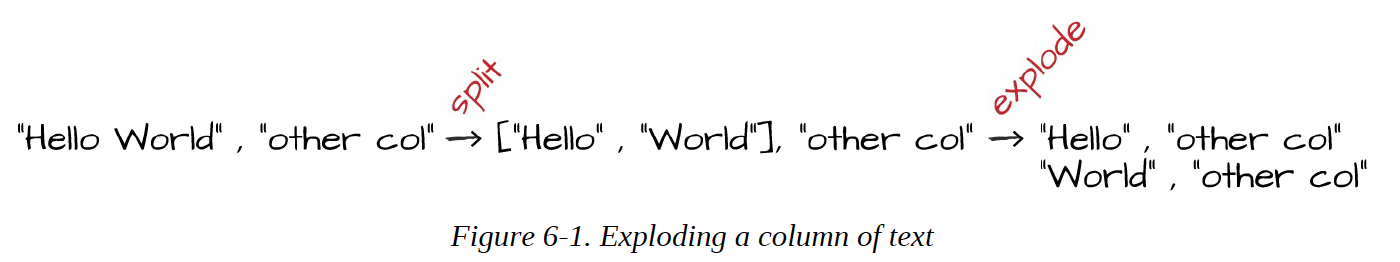

In [68]:
# in Python
from pyspark.sql.functions import split, explode
df.withColumn("splitted", split(col("Description"), " "))\
.withColumn("exploded", explode(col("splitted")))\
.select("Description", "InvoiceNo", "exploded").show(2)
#-- in SQL
#SELECT Description, InvoiceNo, exploded
#FROM (SELECT *, split(Description, " ") as splitted FROM dfTable)
#LATERAL VIEW explode(splitted) as exploded

+--------------------+---------+--------+
|         Description|InvoiceNo|exploded|
+--------------------+---------+--------+
|WHITE HANGING HEA...|   536365|   WHITE|
|WHITE HANGING HEA...|   536365| HANGING|
+--------------------+---------+--------+
only showing top 2 rows



### Maps
Maps are created by using the map function and key-value pairs of columns. You then can select
them just like you might select from an array:

In [69]:
# in Python
from pyspark.sql.functions import create_map
df.select(create_map(col("Description"), col("InvoiceNo")).alias("complex_map"))\
.show(2)
#-- in SQL
#SELECT map(Description, InvoiceNo) as complex_map FROM dfTable
#WHERE Description IS NOT NULL

+--------------------+
|         complex_map|
+--------------------+
|[WHITE HANGING HE...|
|[WHITE METAL LANT...|
+--------------------+
only showing top 2 rows



You can query them by using the proper key. A missing key returns null:

In [74]:
# in Python
from pyspark.sql.functions import lit, col, create_map
df.select(create_map(df["Description"], df["InvoiceNo"]).alias("complex_map"))\
.selectExpr("complex_map['WHITE METAL LANTERN']").show(2)

+--------------------------------+
|complex_map[WHITE METAL LANTERN]|
+--------------------------------+
|                            null|
|                          536365|
+--------------------------------+
only showing top 2 rows



In [76]:
df.select(create_map(col("Description"), col("InvoiceNo")).alias("complex_map"))\
.selectExpr("explode(complex_map)").show(2)

+--------------------+------+
|                 key| value|
+--------------------+------+
|WHITE HANGING HEA...|536365|
| WHITE METAL LANTERN|536365|
+--------------------+------+
only showing top 2 rows



### Working with JSON
Spark has some unique support for working with JSON data. You can operate directly on strings
of JSON in Spark and parse from JSON or extract JSON objects. Let’s begin by creating a JSON
column:

In [77]:
jsonDF = spark.range(1).selectExpr("""
'{"myJSONKey" : {"myJSONValue" : [1, 2, 3]}}' as jsonString""")

You can use the get_json_object to inline query a JSON object, be it a dictionary or array.
You can use json_tuple if this object has only one level of nesting:

In [83]:
from pyspark.sql.functions import get_json_object, json_tuple
jsonDF.select(
get_json_object(col("jsonString"), "$.myJSONKey.myJSONValue[1]").alias("column"),
json_tuple(col("jsonString"), "myJSONKey")).show(2)

+------+--------------------+
|column|                  c0|
+------+--------------------+
|     2|{"myJSONValue":[1...|
+------+--------------------+



You can also turn a StructType into a JSON string by using the to_json function:

In [89]:
from pyspark.sql.functions import to_json
df.selectExpr("(InvoiceNo, Description) as myStruct")\
.select(to_json(col("myStruct")))

DataFrame[to_json(myStruct): string]

This function also accepts a dictionary (map) of parameters that are the same as the JSON data
source. You can use the from_json function to parse this (or other JSON data) back in. This
naturally requires you to specify a schema, and optionally you can specify a map of options, as
well:

In [90]:
from pyspark.sql.functions import from_json
from pyspark.sql.types import *
parseSchema = StructType((
StructField("InvoiceNo",StringType(),True),
StructField("Description",StringType(),True)))
df.selectExpr("(InvoiceNo, Description) as myStruct")\
.select(to_json(col("myStruct")).alias("newJSON"))\
.select(from_json(col("newJSON"), parseSchema), col("newJSON")).show(2)

+--------------------+--------------------+
|  from_json(newJSON)|             newJSON|
+--------------------+--------------------+
|[536365, WHITE HA...|{"InvoiceNo":"536...|
|[536365, WHITE ME...|{"InvoiceNo":"536...|
+--------------------+--------------------+
only showing top 2 rows



# User-Defined Functions
One of the most powerful things that you can do in Spark is define your own functions. These
user-defined functions (UDFs) make it possible for you to write your own custom
transformations using Python or Scala and even use external libraries. UDFs can take and return
one or more columns as input. Spark UDFs are incredibly powerful because you can write them
in several different programming languages; you do not need to create them in an esoteric format
or domain-specific language. They’re just functions that operate on the data, record by record.
By default, these functions are registered as temporary functions to be used in that specific
SparkSession or Context.

Although you can write UDFs in Scala, Python, or Java, there are performance considerations
that you should be aware of. To illustrate this, we’re going to walk through exactly what happens
when you create UDF, pass that into Spark, and then execute code using that UDF.

The first step is the actual function. We’ll create a simple one for this example. Let’s write a
power3 function that takes a number and raises it to a power of three:

In [91]:
udfExampleDF = spark.range(5).toDF("num")
def power3(double_value):
    return double_value ** 3
power3(2.0)

8.0

In this trivial example, we can see that our functions work as expected. We are able to provide an
individual input and produce the expected result (with this simple test case). Thus far, our
expectations for the input are high: it must be a specific type and cannot be a null value (see
“Working with Nulls in Data”).

Now that we’ve created these functions and tested them, we need to register them with Spark so
that we can use them on all of our worker machines. Spark will serialize the function on the
driver and transfer it over the network to all executor processes. This happens regardless of
language.

When you use the function, there are essentially two different things that occur. If the function is
written in Scala or Java, you can use it within the Java Virtual Machine (JVM). This means that
there will be little performance penalty aside from the fact that you can’t take advantage of code
generation capabilities that Spark has for built-in functions. There can be performance issues if
you create or use a lot of objects; we cover that in the section on optimization in Chapter 19.

If the function is written in Python, something quite different happens. Spark starts a Python
process on the worker, serializes all of the data to a format that Python can understand
(remember, it was in the JVM earlier), executes the function row by row on that data in the
Python process, and then finally returns the results of the row operations to the JVM and Spark.
Figure 6-2 provides an overview of the process.
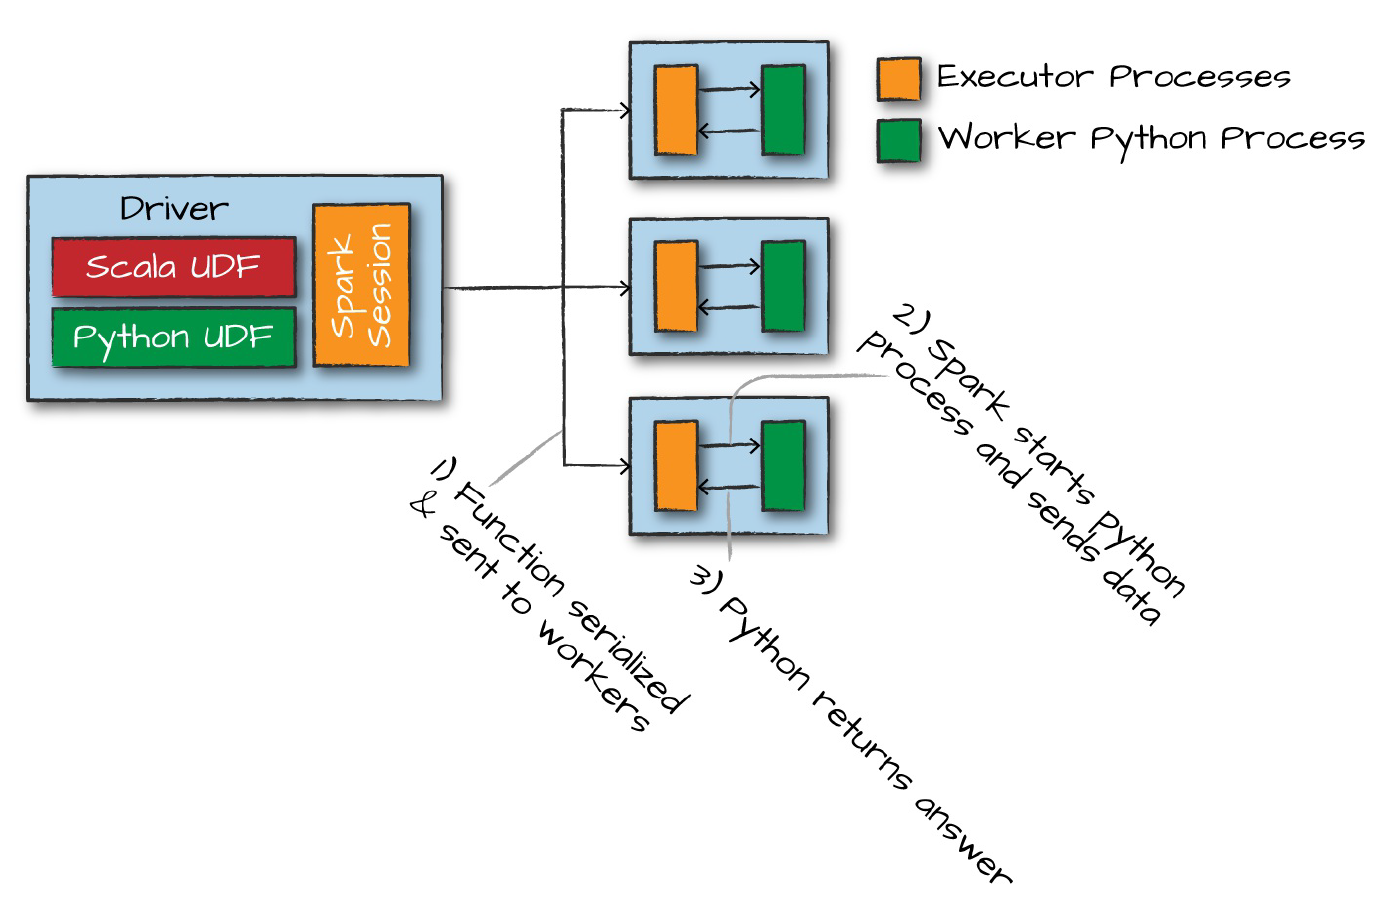

## WARNING
Starting this Python process is expensive, but the real cost is in serializing the data to Python. This is
costly for two reasons: it is an expensive computation, but also, after the data enters Python, Spark
cannot manage the memory of the worker. This means that you could potentially cause a worker to fail
if it becomes resource constrained (because both the JVM and Python are competing for memory on
the same machine). We recommend that you write your UDFs in Scala or Java—the small amount of
time it should take you to write the function in Scala will always yield significant speed ups, and on
top of that, you can still use the function from Python!

Now that you have an understanding of the process, let’s work through an example. First, we
need to register the function to make it available as a DataFrame function:

In [92]:
# Python—first, we register it:
# in Python
from pyspark.sql.functions import udf
power3udf = udf(power3)
#Then, we can use it in our DataFrame code:
# in Python
from pyspark.sql.functions import col
udfExampleDF.select(power3udf(col("num"))).show(2)

+-----------+
|power3(num)|
+-----------+
|          0|
|          1|
+-----------+
only showing top 2 rows



# Conclusion
This chapter demonstrated how easy it is to extend Spark SQL to your own purposes and do so in
a way that is not some esoteric, domain-specific language but rather simple functions that are
easy to test and maintain without even using Spark! This is an amazingly powerful tool that you
can use to specify sophisticated business logic that can run on five rows on your local machines
or on terabytes of data on a 100-node cluster!